In [1]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted',font_scale=1.5)

rcParams['figure.figsize']=22,10

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('AutoEncoderTrainData.csv', parse_dates=['date'], index_col='date')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5508 entries, 2010-05-30 01:00:00 to 2011-01-14 12:00:00
Data columns (total 15 columns):
device_id        5508 non-null int64
device_name      5508 non-null object
region           5508 non-null object
state            5508 non-null object
city             5508 non-null object
manufacturer     5508 non-null object
organization     5508 non-null object
temperature      5508 non-null float64
pressure         5508 non-null float64
waterFraction    5508 non-null float64
current          5508 non-null float64
angle            5508 non-null float64
flow_rate        5508 non-null float64
load             5508 non-null float64
level            5508 non-null float64
dtypes: float64(8), int64(1), object(6)
memory usage: 688.5+ KB


In [6]:
df.drop(columns={'device_id','device_name','region','state','city','manufacturer','organization'},inplace=True,axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5508 entries, 2010-05-30 01:00:00 to 2011-01-14 12:00:00
Data columns (total 8 columns):
temperature      5508 non-null float64
pressure         5508 non-null float64
waterFraction    5508 non-null float64
current          5508 non-null float64
angle            5508 non-null float64
flow_rate        5508 non-null float64
load             5508 non-null float64
level            5508 non-null float64
dtypes: float64(8)
memory usage: 387.3 KB


In [8]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape) 

(5232, 8) (276, 8)


In [10]:
import pickle

In [12]:
from sklearn.preprocessing import MinMaxScaler
st=MinMaxScaler()
scaler = st.fit(train)

with open("transform.pk",'wb') as fin:
    pickle.dump(scaler,fin)

In [13]:
def create_dataset( X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        u = y.iloc[i:(i + time_steps)].values
        ys.append(u)
        
    return np.array(Xs), np.array(ys)

In [14]:
train_tx =pd.DataFrame(scaler.transform(train),columns=df.columns)
print(train_tx.shape)
test_tx =pd.DataFrame(scaler.transform(test), columns=df.columns)
print(test_tx.shape)

(5232, 8)
(276, 8)


In [15]:
test_tx.head()

temperature  pressure  waterFraction   current  angle  flow_rate      load  \
0     0.522732  0.510762       0.636235  0.557793    0.0   0.527355  0.597452   
1     0.522732  0.510762       0.636235  0.550720    0.0   0.378446  0.597452   
2     0.544818  0.356226       0.636235  0.539862    0.0   0.527355  0.597452   
3     0.544818  0.353939       0.636235  0.518012    0.0   0.527355  0.597452   
4     0.601902  0.338883       0.636235  0.490916    0.0   0.527355  0.597452   

      level  
0  0.375307  
1  0.467782  
2  0.500246  
3  0.500246  
4  0.467782

In [16]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
print(len(train_tx))
x_train_, y_train_ = create_dataset(train_tx, train_tx, TIME_STEPS)
x_test_, y_test_ = create_dataset(test_tx,test_tx, TIME_STEPS)

print(x_train_.shape)

5232
(5202, 30, 8)


In [17]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(x_train_.shape[1], x_train_.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train_.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=x_train_.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18688     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 8)             520       
Total params: 52,232
Trainable params: 52,232
Non-trainable params: 0
____________________________________________________

In [19]:
history = model.fit(
    x_train_, y_train_,
    epochs=10,  
    batch_size=30,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/10
139/139 [==============================] - 5s 37ms/step - loss: 0.1575 - val_loss: 0.1113
Epoch 2/10
139/139 [==============================] - 5s 32ms/step - loss: 0.1183 - val_loss: 0.1055
Epoch 3/10
139/139 [==============================] - 5s 34ms/step - loss: 0.1069 - val_loss: 0.0973
Epoch 4/10
139/139 [==============================] - 5s 35ms/step - loss: 0.1007 - val_loss: 0.0960
Epoch 5/10
139/139 [==============================] - 5s 34ms/step - loss: 0.0963 - val_loss: 0.0957
Epoch 6/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0943 - val_loss: 0.0941
Epoch 7/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0931 - val_loss: 0.0916
Epoch 8/10
139/139 [==============================] - 5s 33ms/step - loss: 0.0920 - val_loss: 0.0914
Epoch 9/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0916 - val_loss: 0.0912
Epoch 10/10
139/139 [==============================] - 4s 32ms/step - loss: 0.0902 - val_lo

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open("autoencoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("autoencoder.h5")
print("Saved model to disk")

Saved model to disk


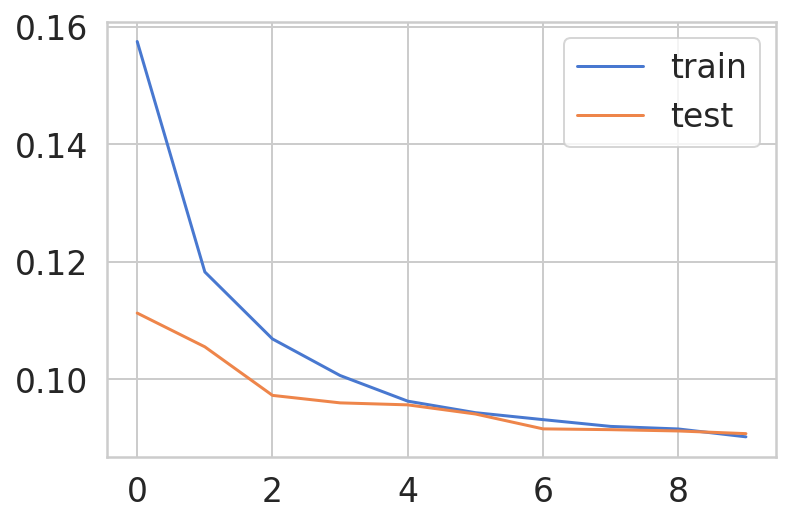

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

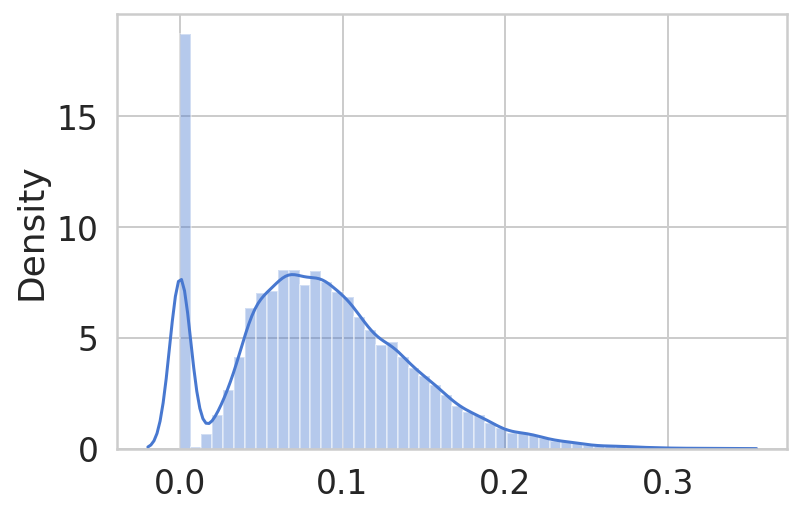

In [22]:
X_train_pred = model.predict(x_train_)
train_mae_loss = np.mean(np.abs(X_train_pred - x_train_), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True)

In [23]:
x_test_.shape

(246, 30, 8)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

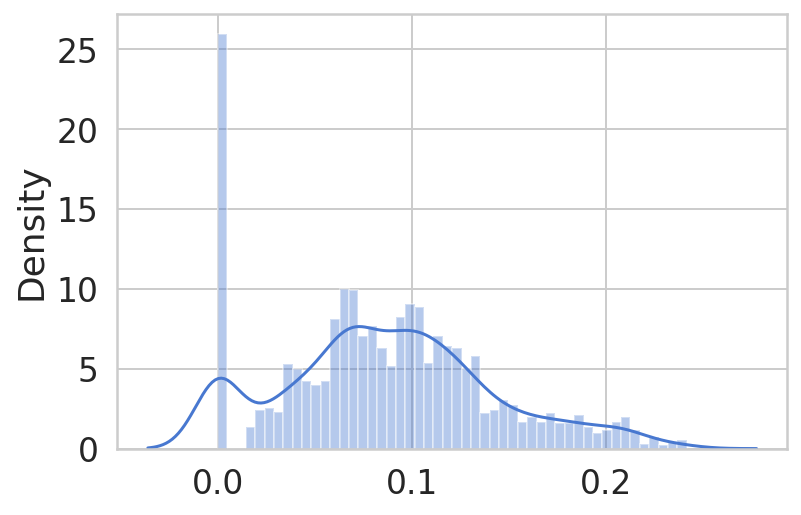

In [24]:
X_test_pred = model.predict(x_test_)
test_mae_loss = np.mean(np.abs(X_test_pred - x_test_), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True)

In [102]:
THRESHOLD = 0.2

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index,columns={'loss','threshold','anomaly'})
#print(test_score_df.head())
test_score_df["loss"] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['temperature'] = test_tx[TIME_STEPS:].temperature

In [103]:
test_score_df.head()

loss  anomaly  threshold
date                                             
2011-01-04 07:00:00  0.068149    False        0.2
2011-01-04 08:00:00  0.074880    False        0.2
2011-01-04 09:00:00  0.080102    False        0.2
2011-01-04 10:00:00  0.082264    False        0.2
2011-01-04 11:00:00  0.082848    False        0.2

In [104]:
test_score_df.shape

(246, 3)

In [105]:
test_score_df.describe()

loss     threshold
count  246.000000  2.460000e+02
mean     0.095254  2.000000e-01
std      0.044041  6.396797e-16
min      0.023819  2.000000e-01
25%      0.062992  2.000000e-01
50%      0.088256  2.000000e-01
75%      0.113643  2.000000e-01
max      0.208955  2.000000e-01

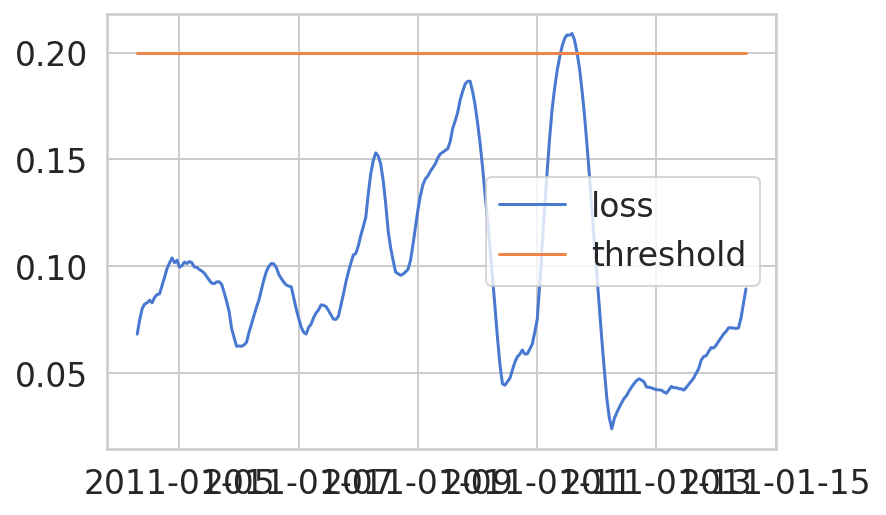

In [106]:
plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.xticks(rotation=5)
plt.legend()

In [107]:
anomalies = test_score_df[test_score_df.anomaly == True]
len(anomalies)

7

In [108]:
new_data=pd.read_csv('AutoEncoder.csv',  index_col='date')

In [109]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5028 entries, 2010-07-29 13:00:00 to 2011-02-24 00:00:00
Data columns (total 10 columns):
region           5028 non-null object
device           5028 non-null int64
temperature      5028 non-null float64
pressure         5028 non-null float64
waterFraction    5028 non-null float64
current          5028 non-null float64
angle            5028 non-null float64
flow_rate        5028 non-null float64
load             5028 non-null float64
level            5028 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 432.1+ KB


In [55]:
new_data.drop(columns={'region','device'},axis=1,inplace=True)



In [56]:
new_data.head()

temperature    pressure  waterFraction   current  angle  \
date                                                                           
2010-07-29 13:00:00     2.245063  212.050000           23.0  0.297273    0.0   
2010-07-29 14:00:00     2.630000  242.600083           37.0  0.324052    0.0   
2010-07-29 15:00:00     5.075349  256.052597           48.0  0.335591    0.0   
2010-07-29 16:00:00     6.793215  263.256839           52.0  0.335591    0.0   
2010-07-29 17:00:00     7.309362  379.831467           52.0  0.335591    0.0   

                     flow_rate    load  level  
date                                           
2010-07-29 13:00:00    89933.0   292.0    0.0  
2010-07-29 14:00:00   131255.0   421.0    0.0  
2010-07-29 15:00:00   131255.0   774.0    0.0  
2010-07-29 16:00:00   131814.0  1304.0 -174.0  
2010-07-29 17:00:00   132178.0  1672.0 -298.0

In [57]:
test2 =pd.DataFrame(scaler.transform(new_data),columns=new_data.columns,index=new_data.index)

In [58]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5028 entries, 2010-07-29 13:00:00 to 2011-02-24 00:00:00
Data columns (total 8 columns):
temperature      5028 non-null float64
pressure         5028 non-null float64
waterFraction    5028 non-null float64
current          5028 non-null float64
angle            5028 non-null float64
flow_rate        5028 non-null float64
load             5028 non-null float64
level            5028 non-null float64
dtypes: float64(8)
memory usage: 353.5+ KB


In [59]:
test2.head()

temperature  pressure  waterFraction   current  angle  \
date                                                                         
2010-07-29 13:00:00     0.237970  0.353939      -0.047128  0.049346    0.0   
2010-07-29 14:00:00     0.278772  0.405707       0.282771  0.068425    0.0   
2010-07-29 15:00:00     0.537971  0.428503       0.541978  0.076645    0.0   
2010-07-29 16:00:00     0.720060  0.440711       0.636235  0.076645    0.0   
2010-07-29 17:00:00     0.774770  0.638249       0.636235  0.076645    0.0   

                     flow_rate      load     level  
date                                                
2010-07-29 13:00:00   0.000000  0.000000  0.939990  
2010-07-29 14:00:00   0.310219  0.054777  0.939990  
2010-07-29 15:00:00   0.310219  0.204671  0.939990  
2010-07-29 16:00:00   0.314416  0.429724  0.854402  
2010-07-29 17:00:00   0.317149  0.585987  0.793409

In [60]:
x_test3,y_test3 = create_dataset(test2,test2, TIME_STEPS)

In [61]:
x_test3.shape

(4998, 30, 8)

In [62]:
test2_pred = model.predict(x_test3)
#test2_mae_loss = np.mean(np.abs(test2_pred - x_test_), axis=1)
#sns.distplot(test_mae_loss, bins=50, kde=True)

In [63]:
type(test2_pred)

numpy.ndarray

In [64]:
test2_pred[0][0]

array([4.9673343e-01, 6.2958324e-01, 6.5504205e-01, 4.3710381e-01,
       2.6278838e-05, 6.3680315e-01, 7.2530913e-01, 5.2234900e-01],
      dtype=float32)

In [65]:
prediction_loss = np.mean(np.abs(test2_pred - x_test3), axis=1)

In [66]:
prediction_loss[0]

array([2.47190407e-01, 8.22020124e-02, 6.86452505e-02, 1.67558502e-01,
       1.45675985e-04, 1.46059016e-01, 1.96772925e-01, 2.19418449e-01])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

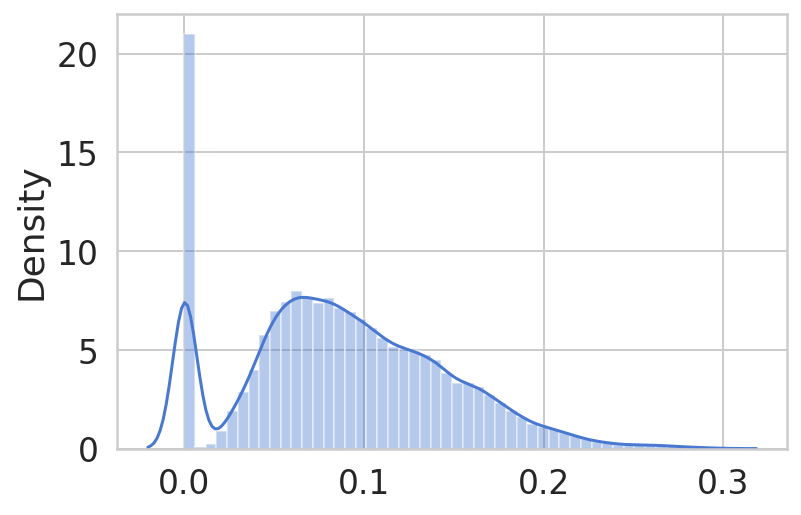

In [67]:
sns.distplot(prediction_loss, bins=50, kde=True)

In [110]:
THRESHOLD = 0.2

test_score_df = pd.DataFrame(index=test2[TIME_STEPS:].index,columns={'loss','threshold','anomaly'})
#print(test_score_df.head())
test_score_df["loss"] = prediction_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

In [111]:
anomalies = test_score_df[test_score_df.anomaly == True]
len(anomalies)

408

In [112]:
test_score_df.describe()

loss     threshold
count  4998.000000  4.998000e+03
mean      0.122425  2.000000e-01
std       0.052254  1.804293e-14
min       0.015416  2.000000e-01
25%       0.082352  2.000000e-01
50%       0.118102  2.000000e-01
75%       0.158051  2.000000e-01
max       0.286158  2.000000e-01